In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import toeplitz
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import RidgeCV
from sklearn.cluster import KMeans
from skimage.filters import threshold_triangle

sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

from bigbrain.brain import get_dims
from bigbrain.brain import bleaching_correction
from bigbrain.brain import z_score_brain
from bigbrain.brain import get_resolution
from bigbrain.brain import load_numpy_brain
from bigbrain.fictrac import load_fictrac
from bigbrain.fictrac import prep_fictrac
from bigbrain.utils import load_timestamps
from bigbrain.utils import get_fly_folders
from bigbrain.utils import send_email
from bigbrain.glm import fit_glm
from bigbrain.glm import save_glm_map
from bigbrain.motcorr import get_motcorr_brain

In [2]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
desired_flies = [21] # 1 index
folders = get_fly_folders(root_path, desired_flies)
print(folders)

fly folders: ['fly_21']
['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_21']


In [3]:
to_load = os.path.join(folders[0], 'glm', 'multivariate_analysis_betas_green_dRotLabZ.nii')
betas = load_numpy_brain(to_load)
betas_flat = np.reshape(betas, (-1,21))

to_load = os.path.join(folders[0], 'glm', 'multivariate_analysis_green_dRotLabZ.nii')
r2 = load_numpy_brain(to_load)
r2_flat = np.ndarray.flatten(r2)

In [4]:
def mask_by_thresh(data, to_mask=None, thresh=None):
    if thresh is None:
        thresh = threshold_triangle(data, nbins=256)
        print('Threshold: {}'.format(thresh))
    mask = data>thresh
    percent_unmasked = np.sum(mask)/np.size(mask)
    print('{}% of voxels passed thresholding ({} out of {}).'.format(
        percent_unmasked*100, np.sum(mask), np.size(mask)))
    if to_mask is None:
        masked = np.multiply(data, mask*1)
    else:
        if data.ndim > to_mask.ndim:
            raise Exception('Data cannot have more dimensions than "to_mask".')
        elif data.ndim < to_mask.ndim:
            mask_tiled = np.tile(mask[:,:,:,np.newaxis], (1,1,1,to_mask.shape[-1]))
            masked = np.multiply(to_mask, mask_tiled*1)
            voxels = to_mask[mask_tiled == True]
            voxels = np.reshape(voxels, (-1, 21))
            voxels_where = np.where(mask_tiled == True)
            voxels_where = np.reshape(np.asarray(voxels_where), (4, -1 , 21))
            voxels_where = voxels_where[:-1,:,0]
        else:
            masked = np.multiply(to_mask, mask*1)
    return masked, voxels, voxels_where

In [6]:
betas_masked, voxels, voxels_where = mask_by_thresh(data=r2, to_mask=betas, thresh=0.01)

0.6125731430618582% of voxels passed thresholding (3283 out of 535936).


In [7]:
def cluster_brain(voxels, voxels_where, r2, n_clusters):
    kmeans = KMeans(n_clusters).fit(voxels)

    clusters = [[] for i in range(n_clusters)]
    for i in range(len(kmeans.labels_)):
        clusters[kmeans.labels_[i]].append(voxels[i,:])

    clustered_brain = np.zeros(r2.shape)
    for i in range(voxels_where.shape[-1]): 
        clustered_brain[voxels_where[0,i], voxels_where[1,i], voxels_where[2,i]] = kmeans.labels_[i]+1
    return clustered_brain

In [316]:
for i in range(2,7):
    clustered_brain = cluster_brain(voxels, voxels_where, r2, n_clusters=i+1)
    save_file = os.path.join(folders[0], 'clustering', 'rotation_{}clusters.nii'.format(i+1))
    #brain_to_save = np.swapaxes(brain_z, 0, 1)
    ants.image_write(ants.from_numpy(clustered_brain), save_file)

In [8]:
clustered_brain = cluster_brain(voxels, voxels_where, r2, n_clusters=2)

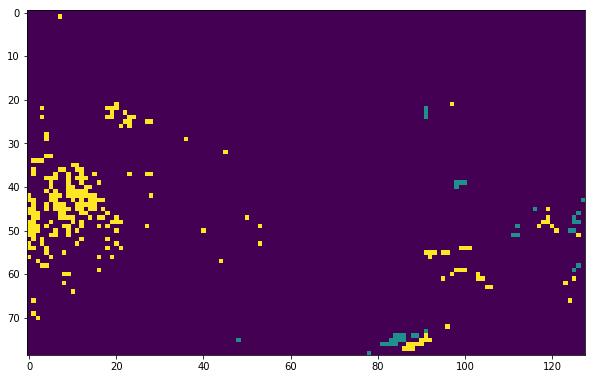

In [313]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(clustered_brain[:,:,17],0,1))
plt.show()

In [9]:
betas_masked_flat = np.reshape(betas_masked, (-1,21))

In [10]:
voxels_re = np.reshape(voxels, (-1, 21))

In [286]:
#Recreate brain from masked voxels



clustered_brain = np.zeros(r2.shape)
for i in range(where_re.shape[-1]): 
    clustered_brain[where_re[0,i], where_re[1,i], where_re[2,i]] = 1

In [268]:
voxels_re.shape

(3283, 21)

In [261]:
where_re.shape

(4, 3283, 21)

In [263]:
where_re[:,0,20]

array([ 0,  3, 28, 20])

In [82]:
masked.shape

(128, 79, 53, 21)

In [240]:
voxels.shape

(68943,)

In [258]:
np.asarray(voxels_where)[:,50000]

array([89, 57, 34, 20])

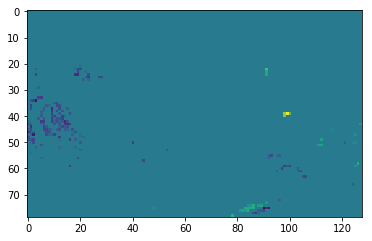

In [86]:
plt.imshow(np.swapaxes(betas_masked[:,:,17,10],0,1))
plt.show()

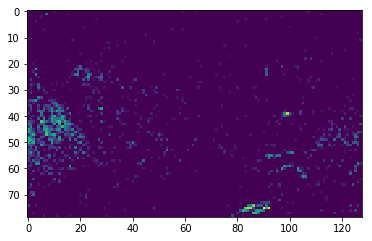

In [35]:
plt.imshow(np.swapaxes(r2[:,:,17],0,1))
plt.show()

In [11]:
new_rate = 412 #in ms
pre_dur = (-412*10)-1 #in ms
post_dur = (412*10)+1 #in ms

row_vector_pre = np.flip(np.arange(0,pre_dur,-new_rate),axis=0)
row_vector_post = np.arange(0,post_dur,new_rate)
row_vector = np.unique(np.concatenate((row_vector_pre, row_vector_post)))

In [12]:
row_vector

array([-4120, -3708, -3296, -2884, -2472, -2060, -1648, -1236,  -824,
        -412,     0,   412,   824,  1236,  1648,  2060,  2472,  2884,
        3296,  3708,  4120])

In [129]:
timestamps = load_timestamps(folders[0])

Loading timestamps.
loading timestamp data from hdf5 file... done
 load_timestamps Elapsed time: 0.0005145549774169921min


In [133]:
np.diff(timestamps[:,0])


array([411.95068, 411.95068, 411.95068, ..., 411.95068, 411.95068,
       411.95068])

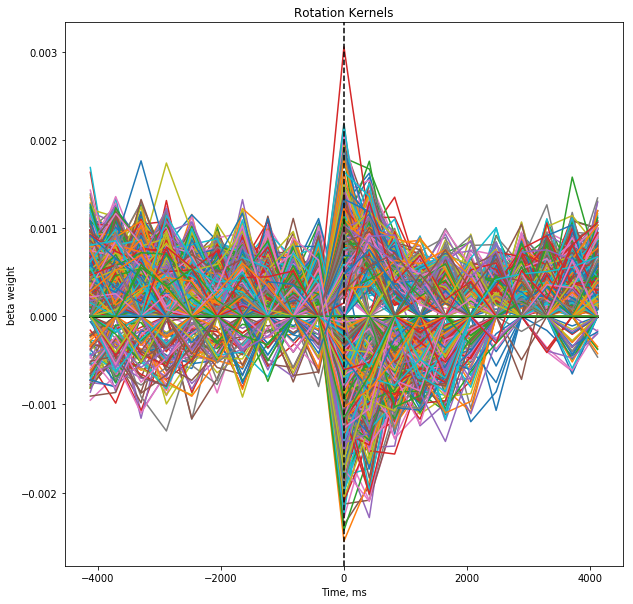

In [13]:
plt.figure(figsize=(10,10))
plt.title('Rotation Kernels')
plt.plot(row_vector, np.swapaxes(voxels_re,0,1))
plt.xlabel('Time, ms')
plt.ylabel("beta weight")
plt.axvline(0,color='k',linestyle='--')
plt.show()

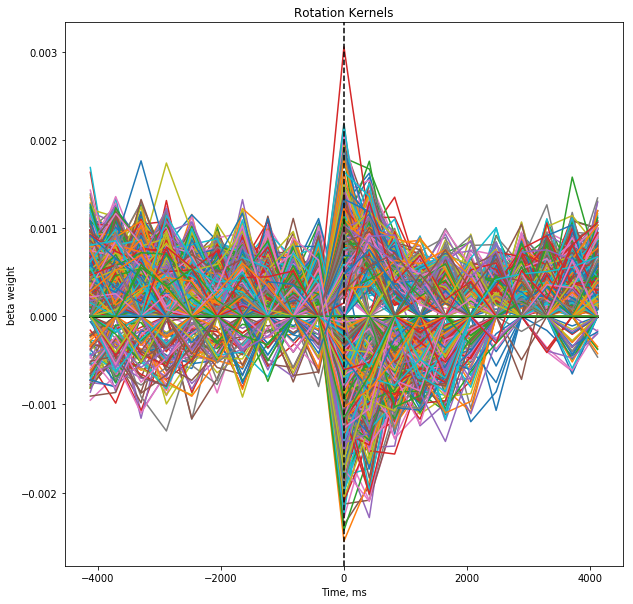

In [156]:
plt.figure(figsize=(10,10))
plt.title('Rotation Kernels')
plt.plot(row_vector, np.swapaxes(voxels_re,0,1))
plt.xlabel('Time, ms')
plt.ylabel("beta weight")
plt.axvline(0,color='k',linestyle='--')
plt.show()

In [122]:
voxels_re.shape

(3283, 21)

In [ ]:
#Recreate brain from masked voxels

where_re = np.reshape(np.asarray(voxels_where), (4, -1 , 21))
where_re = where_re[:-1,:,0]


In [292]:

clustered_brain = np.zeros(r2.shape)
for i in range(where_re.shape[-1]): 
    clustered_brain[where_re[0,i], where_re[1,i], where_re[2,i]] = kmeans.labels_[i]

In [289]:
where_re.shape

(3, 3283)

In [290]:
voxels_re.shape

(3283, 21)

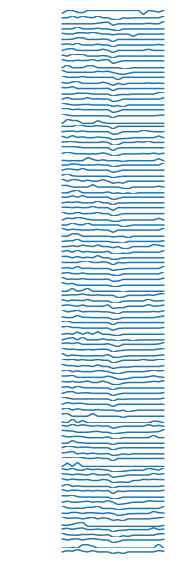

In [126]:
plt.figure(figsize=(2,10))
for i in range(100):
    plt.subplot(100,1,i+1)
    plt.plot(voxels_re[i,:])
    plt.axis('off')
plt.show()

In [14]:
n_clusters = 2
kmeans = KMeans(n_clusters).fit(voxels_re)

In [15]:
clusters = [[] for i in range(n_clusters)]
for i in range(len(kmeans.labels_)):
    clusters[kmeans.labels_[i]].append(voxels_re[i,:])

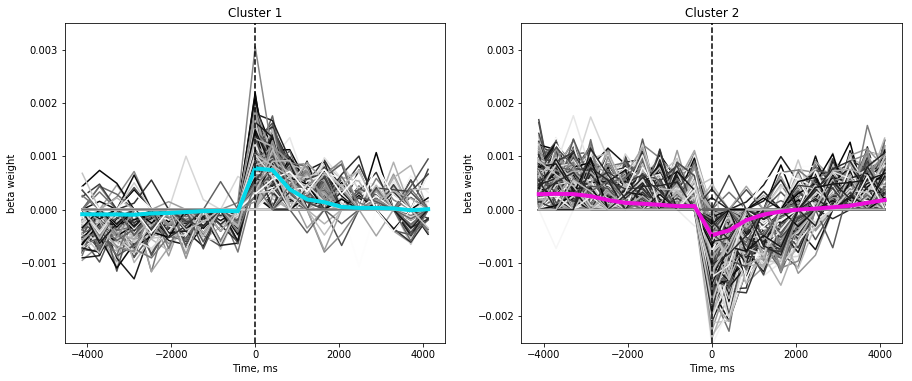

In [17]:
plt.figure(figsize=(15,20))

colors = ['xkcd:aqua blue', 'xkcd:fuchsia', 'xkcd:seafoam',
          'xkcd:light orange', 'xkcd:goldenrod', 'xkcd:scarlet']

for j in range(n_clusters):
    
    plt.subplot(3,2,j+1)
    
    cluster = np.asarray(clusters[j])
    for i in range(np.shape(clusters[j])[0]):
        plt.plot(row_vector, cluster[i,:],color=str(np.random.uniform()))
        
    plt.plot(row_vector, kmeans.cluster_centers_[j],linewidth=4,color=colors[j])
    plt.axvline(0,color='k',linestyle='--')
    plt.title('Cluster {}'.format(j+1))
    plt.xlabel('Time, ms')
    plt.ylabel('beta weight')
    plt.ylim(-0.0025, 0.0035)

save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_21/clustering/clusters.png'
plt.savefig(save_file, bbox_inches='tight', dpi=300)
plt.show()

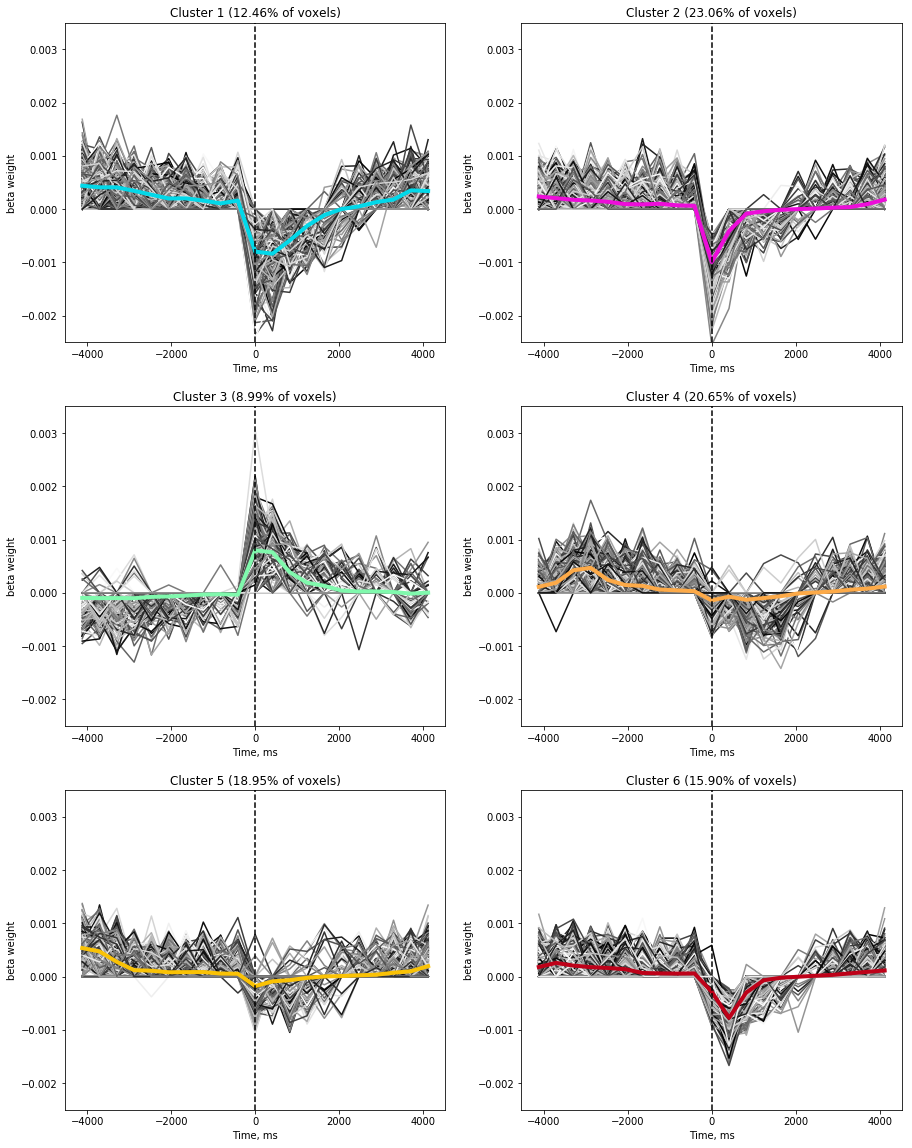

In [236]:
plt.figure(figsize=(15,20))

colors = ['xkcd:aqua blue', 'xkcd:fuchsia', 'xkcd:seafoam',
          'xkcd:light orange', 'xkcd:goldenrod', 'xkcd:scarlet']

for j in range(n_clusters):
    
    plt.subplot(3,2,j+1)
    
    cluster = np.asarray(clusters[j])
    for i in range(np.shape(clusters[j])[0]):
        plt.plot(row_vector, cluster[i,:],color=str(np.random.uniform()))
        
    plt.plot(row_vector, kmeans.cluster_centers_[j],linewidth=4,color=colors[j])
    plt.axvline(0,color='k',linestyle='--')
    plt.title('Cluster {} ({:.2f}% of voxels)'.format(j+1, (cluster.shape[0]/voxels_re.shape[0])*100))
    plt.xlabel('Time, ms')
    plt.ylabel('beta weight')
    plt.ylim(-0.0025, 0.0035)
    
plt.show()

In [196]:
np.asarray(clusters['0'])[0,:]

array([ 0.        ,  0.        ,  0.00061884,  0.        ,  0.00055277,
        0.00018068,  0.        ,  0.00061333,  0.        ,  0.        ,
       -0.00055223, -0.00066869,  0.        , -0.00015158,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00052983])

In [106]:
kmeans.cluster_centers_.shape

(5, 21)

In [14]:
kmeans.cluster_centers_.shape

(2, 21)